# Federal University of Campina Grande (UFCG)
# Author: Rayana Souza Rocha

In [209]:
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-whitegrid')
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, median_absolute_error

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [210]:
eleicoes = pd.read_csv('eleicoes_2006_a_2010.csv')
eleicoes[:3]

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,votos
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.0,2766.666667,NaN,...,14,14,16583.60,1184.542857,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,8579
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.0,1755.846154,6625.0,...,24,23,20325.99,883.738696,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,2757
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,148120.8,9257.550000,2250.0,...,123,108,146011.70,1351.960185,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,17428


## Observando os dados

In [211]:
eleicoes.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ano,7330.0,2.008151e+03,1.994416e+00,2006.00,2006.000000,2.010000e+03,2.010000e+03,2.010000e+03
sequencial_candidato,7330.0,9.179127e+10,9.924629e+10,10001.00,10565.000000,5.000000e+10,1.900000e+11,2.700000e+11
quantidade_doacoes,7330.0,2.831010e+01,1.186551e+02,1.00,4.000000,9.000000e+00,2.400000e+01,6.997000e+03
quantidade_doadores,7330.0,2.581746e+01,1.036594e+02,1.00,4.000000,8.000000e+00,2.200000e+01,5.800000e+03
total_receita,7169.0,1.544899e+05,3.953880e+05,0.00,2700.000000,1.209578e+04,8.929956e+04,4.539727e+06
media_receita,7169.0,5.485598e+03,1.411653e+04,0.00,622.857143,1.540543e+03,4.662500e+03,5.001800e+05
recursos_de_outros_candidatos/comites,4940.0,3.002116e+04,1.280932e+05,2.41,1180.000000,3.522570e+03,1.327550e+04,3.664205e+06
recursos_de_pessoas_fisicas,4647.0,3.730931e+04,8.215398e+04,0.03,2000.000000,9.000000e+03,3.756234e+04,1.403049e+06
recursos_de_pessoas_juridicas,3354.0,1.761195e+05,3.517541e+05,0.00,3422.500000,2.612000e+04,1.755218e+05,3.178226e+06
recursos_proprios,4942.0,3.914169e+04,1.839980e+05,0.00,1177.232500,5.000000e+03,2.027459e+04,5.525600e+06


## Distribuição das variáveis 

array([[<AxesSubplot: title={'center': 'Total de Receita'}>]],
      dtype=object)

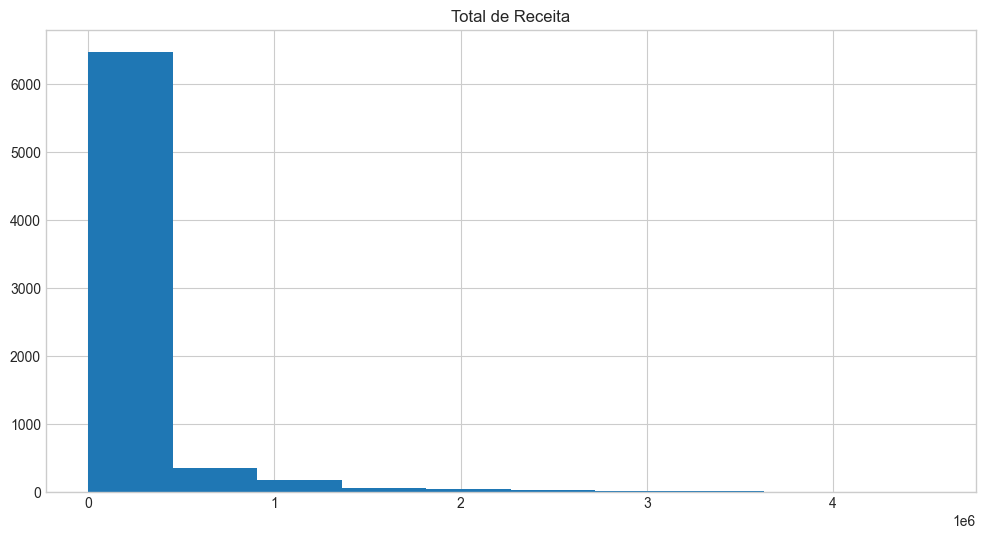

In [212]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
var = pd.DataFrame({"Total de Receita":eleicoes['total_receita']})

var.hist()

array([[<AxesSubplot: title={'center': 'log(total_receita + 1)'}>]],
      dtype=object)

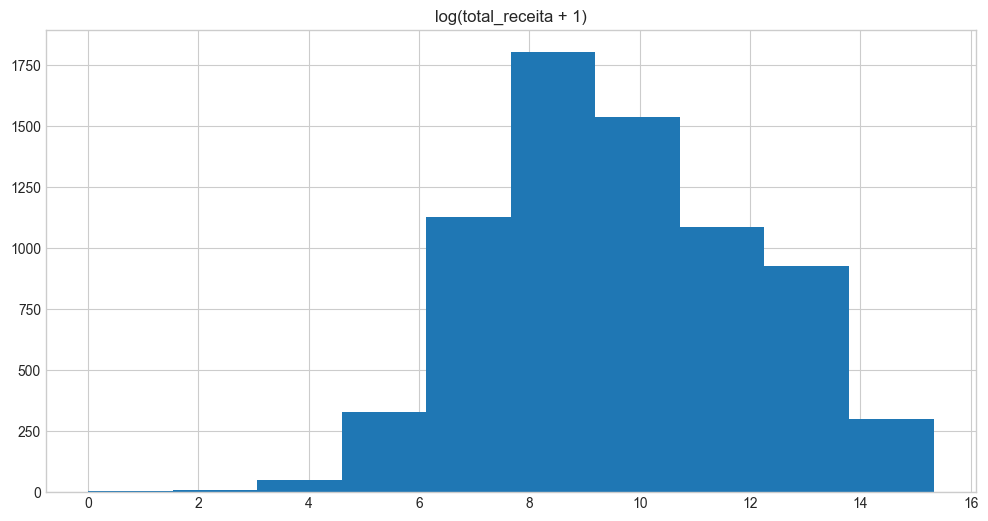

In [213]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
var = pd.DataFrame({"log(total_receita + 1)":np.log1p(eleicoes['total_receita'])})

var.hist()

array([[<AxesSubplot: title={'center': 'Votos'}>]], dtype=object)

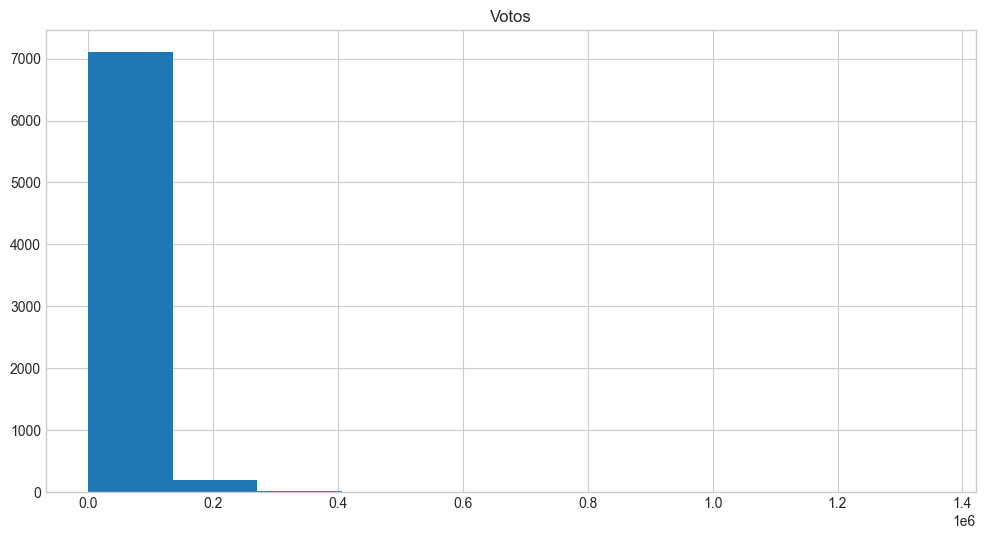

In [214]:
var = pd.DataFrame({"Votos":eleicoes['votos']})

var.hist()

Selecionando as variáveis numéricas

In [215]:
numeric_features = eleicoes.dtypes[eleicoes.dtypes != "object"].index
eleicoes[numeric_features][:5]

,ano,sequencial_candidato,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,votos
0,2006,10001,6,6,16600.00,2766.666667,NaN,9000.0,6300.00,1300.0,14,14,16583.60,1184.542857,8579
1,2006,10002,13,13,22826.00,1755.846154,6625.0,15000.0,1000.00,201.0,24,23,20325.99,883.738696,2757
2,2006,10002,17,16,148120.80,9257.550000,2250.0,34150.0,62220.80,59500.0,123,108,146011.70,1351.960185,17428
3,2006,10002,6,6,3001.12,500.186667,NaN,1150.0,1101.12,750.0,8,8,3001.12,375.140000,1193
4,2006,10003,48,48,NaN,NaN,NaN,50878.0,NaN,68942.0,133,120,116416.64,970.138667,29401


Verificando o viés das variáveis numéricas

In [216]:
skewed_features = eleicoes[numeric_features].apply(lambda x: x.dropna().skew())
skewed_features

ano                                      -0.151624
sequencial_candidato                      0.447496
quantidade_doacoes                       39.982260
quantidade_doadores                      37.541762
total_receita                             4.599988
media_receita                            12.105833
recursos_de_outros_candidatos/comites    13.892631
recursos_de_pessoas_fisicas               6.800271
recursos_de_pessoas_juridicas             3.431190
recursos_proprios                        15.782559
quantidade_despesas                       8.546077
quantidade_fornecedores                   8.424869
total_despesa                             4.534959
media_despesa                            66.379222
votos                                     6.669571
dtype: float64

Selecionando os atributos com viés acima de 0.75

In [217]:
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features

quantidade_doacoes                       39.982260
quantidade_doadores                      37.541762
total_receita                             4.599988
media_receita                            12.105833
recursos_de_outros_candidatos/comites    13.892631
recursos_de_pessoas_fisicas               6.800271
recursos_de_pessoas_juridicas             3.431190
recursos_proprios                        15.782559
quantidade_despesas                       8.546077
quantidade_fornecedores                   8.424869
total_despesa                             4.534959
media_despesa                            66.379222
votos                                     6.669571
dtype: float64

Aplicando transformação logarítmica em todos os dados selecionados em skewed_features

In [218]:
skewed_features = skewed_features.index

eleicoes[skewed_features] = np.log1p(eleicoes[skewed_features])
eleicoes[numeric_features][:5]

,ano,sequencial_candidato,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,votos
0,2006,10001,1.945910,1.945910,9.717218,7.925760,NaN,9.105091,8.748464,7.170888,2.708050,2.708050,9.716230,7.077956,9.057189
1,2006,10002,2.639057,2.639057,10.035699,7.471276,8.798757,9.615872,6.908755,5.308268,3.218876,3.178054,9.919705,6.785292,7.922261
2,2006,10002,2.890372,2.833213,11.905790,9.133303,7.719130,10.438547,11.038461,10.993748,4.820282,4.691348,11.891449,7.210050,9.765891
3,2006,10002,1.945910,1.945910,8.007074,6.216979,NaN,7.048386,7.004991,6.621406,2.197225,2.197225,8.007074,5.929961,7.085064
4,2006,10003,3.891820,3.891820,NaN,NaN,NaN,10.837206,NaN,11.141035,4.897840,4.795791,11.664939,6.878469,10.288818


## Transformando variáveis categóricas

Verificando a quantidade de linhas e colunas do DataFrame antes da tranformação das variáveis categóricas

In [219]:
eleicoes.shape

(7330, 23)

Convertendo atributos categóricos em valores modelo

In [220]:
eleicoes = pd.get_dummies(eleicoes)
eleicoes.shape

(7330, 7038)

In [221]:
eleicoes[:3]

,ano,sequencial_candidato,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,...,"ocupacao_TÉCNICO DE OBRAS CIVIS, ESTRADAS, SANEAMENTO E ASSEMELHADOS",ocupacao_TÉCNICO EM AGRONOMIA E AGRIMENSURA,ocupacao_TÉCNICO EM EDIFICAÇÕES,ocupacao_TÉCNICO EM INFORMÁTICA,ocupacao_VENDEDOR DE COMÉRCIO VAREJISTA E ATACADISTA,"ocupacao_VENDEDOR PRACISTA, REPRESENTANTE, CAIXEIRO-VIAJANTE E ASSEMELHADOS",ocupacao_VEREADOR,ocupacao_VETERINÁRIO,ocupacao_VIGILANTE,ocupacao_ZOOTECNISTA
0,2006,10001,1.945910,1.945910,9.717218,7.925760,NaN,9.105091,8.748464,7.170888,...,0,0,0,0,0,0,1,0,0,0
1,2006,10002,2.639057,2.639057,10.035699,7.471276,8.798757,9.615872,6.908755,5.308268,...,0,0,0,0,0,0,0,0,0,0
2,2006,10002,2.890372,2.833213,11.905790,9.133303,7.719130,10.438547,11.038461,10.993748,...,0,0,0,0,0,0,0,0,0,0


In [222]:
eleicoes_mean = eleicoes.fillna(eleicoes.mean())

In [223]:
eleicoes_zero = eleicoes.fillna(0)

## Separando dados
Vamos utilizar um `DataFrame` montado de forma aleatória tanto com dados de 2006 quanto com dados de 2010.
E utilizar para a transformação dos valores NaN a opção 1 que preenche os valores NA's com a média de valores de cada coluna.

In [224]:
eleicoes = eleicoes_mean
n = int(7330/2)
sample = eleicoes.sample(n=n)
eleicoes.shape

(7330, 7038)

In [225]:
sample = sample.drop(['sequencial_candidato', 'media_receita', 'media_despesa'], axis=1)

In [226]:
sample[(sample.ano==2006)].shape

(1670, 7035)

In [227]:
sample[(sample.ano==2010)].shape

(1995, 7035)

In [228]:
train = sample.query('ano == 2006')
test = sample.query('ano == 2010')

## Criando matrizes para o sklearn

In [229]:
x_train = train.drop('votos', axis=1)
y_train = train['votos']

x_test = test.drop('votos', axis=1)
y_test = test['votos']

x_all = sample.drop('votos', axis=1)
y_all = sample['votos']

Função para criar visualização do Resíduo X Predições

In [230]:
def vis_residuos_vs_predicoes(y_pred, y_real, titulo):
    matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
    predicoes = pd.DataFrame({"predicoes":y_pred, "valor_real":y_real})
    predicoes["residuos"] = predicoes["valor_real"] - predicoes["predicoes"]
    predicoes.plot(x = "predicoes", y = "residuos",kind = "scatter")
    plt.title(titulo)


# Modelos de Regressão

## 1 - Regressão sem regularização

Treinando o modelo com os dados de treino

In [231]:
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression()

Predizendo os valores de y para dos conjunto de teste

In [232]:
y_pred_model_reg = reg.predict(x_test)
y_pred_model_reg

array([ 6.72130144,  8.02414194, 13.19043955, ..., 10.58611364,
        9.37315157, 11.13177188])

#### Calculando métricas para avaliação do modelo

**Coeficientes calculados para os atributos**

In [233]:
reg.coef_

array([ 0.20427318, -0.48324728,  0.76653689, ...,  0.37883832,
       -1.0039787 ,  0.        ])

**MSE** - Média do quadrado do erro

In [234]:
mse = mean_squared_error(y_test, y_pred_model_reg)
mse

2.971106446227179

### RMSE - Regressão sem regularização

In [235]:
np.sqrt(mse)

1.7236897766788486

**R²**

In [236]:
r2_score(y_test, y_pred_model_reg)

0.2726348822926027

In [237]:
explained_variance_score(y_test, y_pred_model_reg)

0.7451628212329452

## 1.1 - Resíduos x Predições: Regressão sem regularização

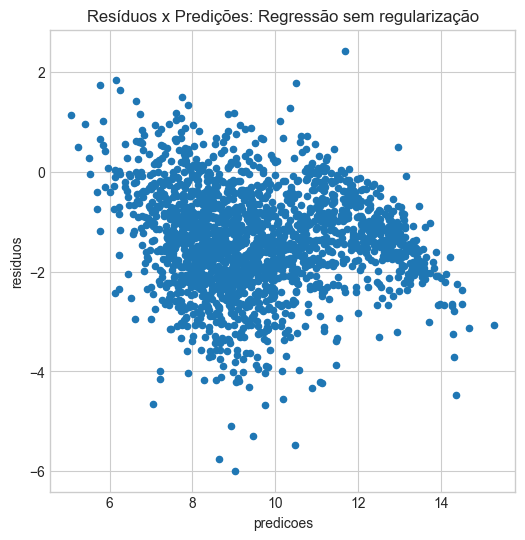

In [238]:
vis_residuos_vs_predicoes(y_pred_model_reg, y_test, "Resíduos x Predições: Regressão sem regularização")

Função para calcular as métricas RMSE e R² do modelo com validação cruzada.

In [239]:
def calc_rmse(model, cv):
    rmse = np.sqrt(-cross_val_score(model, x_all, y_all, scoring="neg_mean_squared_error", cv=cv))
    print("RMSE is: {0} ".format(rmse))
    return rmse

In [240]:
def calc_r2(model, cv):
    r2 = np.sqrt(cross_val_score(model, x_all, y_all, scoring="r2", cv=cv))
    print("R² is: {0} ".format(r2))
    return r2

In [241]:
def calc_variance(model, cv):
    explained_variance = np.sqrt(cross_val_score(model, x_train, y_train, scoring="explained_variance", cv=cv))
    print("Variance is: {0} ".format(explained_variance))
    return explained_variance

Função para gerar visualização dos alphas x medidas de validação

In [242]:
def gerar_vis_validacao(measures, alphas, title_measure):
    matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
    data = pd.Series(measures, index=alphas)
    data.plot(title = "Validação")
    plt.xlabel("alpha")
    plt.ylabel(title_measure)

## 2 - Ridge
Atribuindo alguns valores para alfa e verificando como o RMSE se comporta

In [243]:
alphas = [0.2, 0.5, 2, 5, 7]
cv = 5

In [244]:
ridge_rmse = [calc_rmse(Ridge(alpha=alpha), cv).mean() 
            for alpha in alphas]

ridge_rmse

RMSE is: [0.9338281  1.00780731 0.93245618 0.94163344 0.96292686] 
RMSE is: [0.92969259 1.00161353 0.92649204 0.93400248 0.96130136] 
RMSE is: [0.92844276 0.99800335 0.92133452 0.92749218 0.96185894] 
RMSE is: [0.93036337 0.99940825 0.92046144 0.92408887 0.96401116] 
RMSE is: [0.93146482 1.0003546  0.92053053 0.92290171 0.96501495] 


[0.9557303767766265,
 0.9506203999969598,
 0.9474263492780345,
 0.9476666189274484,
 0.9480533213366114]

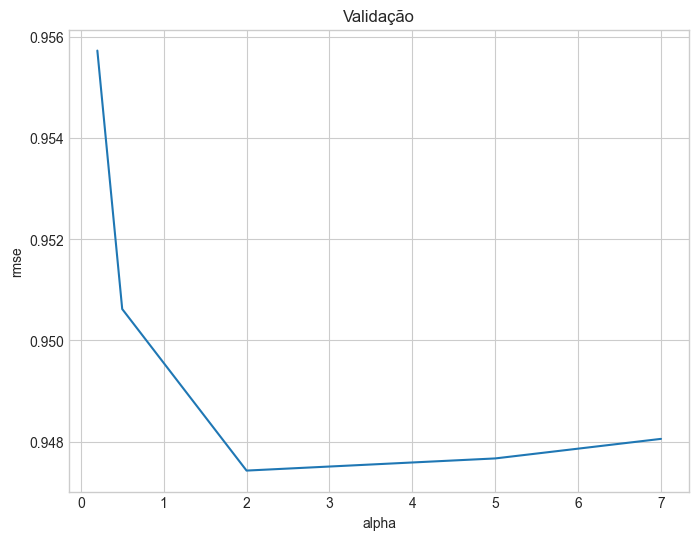

In [245]:
gerar_vis_validacao(ridge_rmse, alphas, "rmse")

In [246]:
ridge_r2 = [calc_r2(Ridge(alpha=alpha), cv).mean() 
            for alpha in alphas]

ridge_r2

R² is: [0.8800063  0.86245729 0.8759855  0.87583249 0.88375033] 
R² is: [0.88113831 0.86427519 0.87767717 0.87797629 0.88416817] 
R² is: [0.88147916 0.86532787 0.87912869 0.87978738 0.88402494] 
R² is: [0.88095514 0.86491883 0.87937337 0.88072763 0.8834711 ] 
R² is: [0.880654   0.86464285 0.87935402 0.88105456 0.88321225] 


[0.875606382423948,
 0.8770470257700269,
 0.8779496089516228,
 0.877889213669999,
 0.8777835367061257]

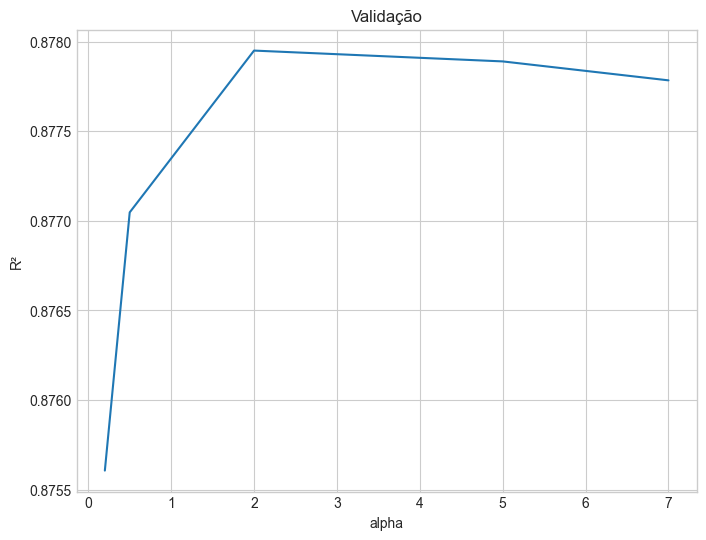

In [247]:
gerar_vis_validacao(ridge_r2, alphas, "R²")

In [248]:
ridge_variance = [calc_variance(Ridge(alpha=alpha), cv).mean() 
            for alpha in alphas]

ridge_variance

Variance is: [0.87762505 0.85821977 0.85249668 0.84840754 0.87419016] 
Variance is: [0.87770089 0.8584509  0.85318459 0.84914585 0.87494927] 
Variance is: [0.87770589 0.85899677 0.85516513 0.85155949 0.87701406] 
Variance is: [0.87734119 0.85915764 0.85667024 0.85399515 0.87824607] 
Variance is: [0.87703201 0.85901479 0.85704415 0.85489976 0.87839174] 


[0.862187839950203,
 0.8626863019181407,
 0.8640882699215309,
 0.865082056501239,
 0.8652764897846262]

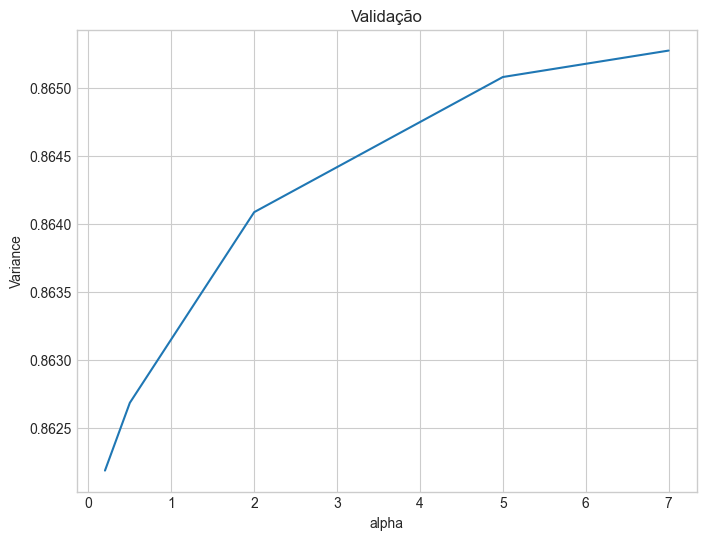

In [249]:
gerar_vis_validacao(ridge_variance, alphas, "Variance")

### Criando um modelo Ridge com o alfa que obteve o menor RMSE

In [250]:
model_ridge = Ridge(alpha=2)

model_ridge.fit(x_train, y_train)

Ridge(alpha=2)

In [251]:
y_pred_model_ridge = model_ridge.predict(x_test)
y_pred_model_ridge

array([ 5.88071229,  7.25069304, 12.44179964, ...,  9.73166592,
        8.61065423, 10.04562367])

### RMSE - Ridge

In [252]:
mse_ridge = mean_squared_error(y_test, y_pred_model_ridge)
mse_ridge

1.3042792439253508

In [253]:
np.sqrt(mse)

1.7236897766788486

### R²

In [254]:
r2_score(y_test, y_pred_model_ridge)

0.680695645561351

## 2.1 - Resíduos x Predições: Ridge

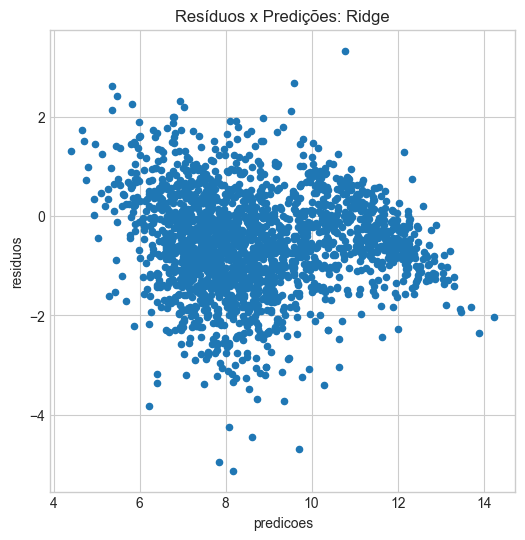

In [255]:
vis_residuos_vs_predicoes(y_pred_model_ridge, y_test, "Resíduos x Predições: Ridge")

Podemos observar que o modelo apresenta uma adaquabilidade melhor do que o modelo de regressão linear sem regularização, devido aos dados do resíduo estarem mais centralizados. Nos histogramas podemos observar que as predições conseguiram se aproximar melhor dos dados reais com relação a distribuição.

Text(0.5, 1.0, 'Distribuição dos Resíduos')

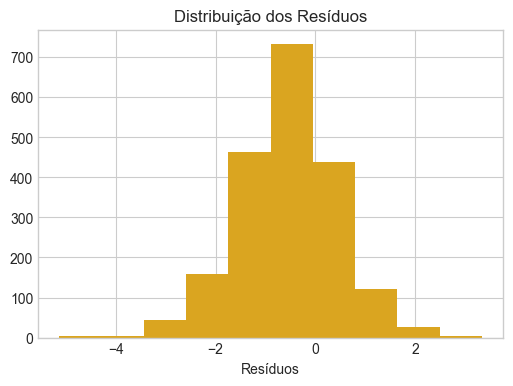

In [256]:
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)
residuos = y_test - y_pred_model_ridge
residuos.hist(color = "goldenrod")
plt.xlabel('Resíduos')
plt.title('Distribuição dos Resíduos')

Text(0.5, 1.0, 'Distribuição das Predições')

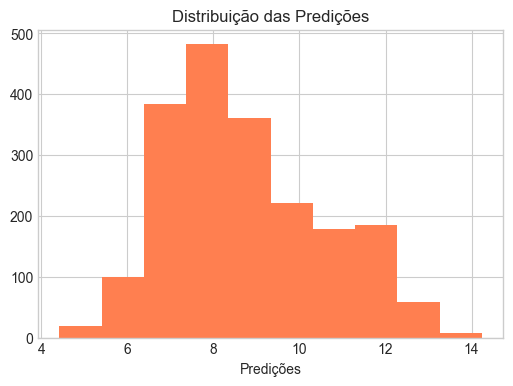

In [257]:
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)
pd.Series(y_pred_model_ridge).hist(color = "coral")
plt.xlabel('Predições')
plt.title('Distribuição das Predições')

Text(0.5, 1.0, 'Distribuição dos Valores Reais')

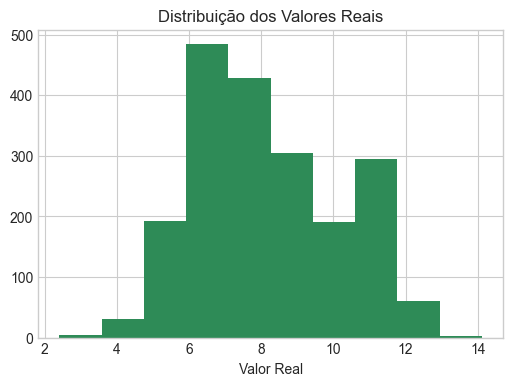

In [258]:
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)
pd.Series(y_test).hist(color = "seagreen")
plt.xlabel('Valor Real')
plt.title('Distribuição dos Valores Reais')

## 3 - Lasso

In [259]:
model_lasso = LassoCV(alphas=[1, 0.1, 0.001, 0.005], max_iter=3000).fit(x_train, y_train)

model_lasso

LassoCV(alphas=[1, 0.1, 0.001, 0.005], max_iter=3000)

Verificando qual foi o alfa escolhido através da `cross validation`

In [260]:
model_lasso.alpha_

0.001

In [261]:
def calc_rmse_lasso(model, cv):
    rmse = np.sqrt(-cross_val_score(model, x_train, y_train, scoring="neg_mean_squared_error", cv=cv))
    print("RMSE is: {0} ".format(rmse))
    return rmse

### RMSE Lasso

In [262]:
rmse_lasso = calc_rmse_lasso(model_lasso, 3).mean()
rmse_lasso

RMSE is: [0.98597085 0.98675667 0.94830912] 


0.9736788794596959

In [263]:
y_pred_model_lasso = model_lasso.predict(x_test)
y_pred_model_lasso

array([ 5.92427656,  7.46554424, 12.46433678, ...,  9.67430244,
        8.72800043, 10.0727291 ])

### R²

In [264]:
model_lasso.score(x_test, y_test)

0.6835636865351187

In [265]:
coef = pd.Series(model_lasso.coef_, index = x_train.columns)
print("Lasso selecionou " + str(sum(coef != 0)) + " variáveis e rejeitou " + 
      str(sum(coef == 0)) + " variáveis")

Lasso selecionou 206 variáveis e rejeitou 6828 variáveis


In [266]:
descricao_coeficientes = pd.concat([coef.sort_values().head(10),
                                   coef.sort_values().tail(15)])

descricao_coeficientes

nome_MAURO DE OLIVEIRA CARVALHO             -2.369889
nome_DEMOSTENES BATISTA VERAS FILHO         -2.014713
nome_MARIA LUIZA MOREIRA                    -1.758887
nome_GERSON BENEDICTO                       -1.393845
nome_ANTONIO ATILANO SOUSA AYRES DE MOURA   -1.121041
uf_DF                                       -1.009991
uf_RR                                       -0.972200
nome_DAGOBERTO DA SILVA DANTAS              -0.954574
nome_ANTONIO CARLOS DE LIMA                 -0.954045
nome_MARTA CRISTINA LUCHI DE LIMA           -0.943799
nome_PAULO SALIM MALUF                       0.629378
nome_BERNARDINO BARRETO DE OLIVEIRA          0.644135
ocupacao_DEPUTADO                            0.664313
ocupacao_MILITAR REFORMADO                   0.708157
nome_JAIR MESSIAS BOLSONARO                  0.808128
nome_MARINA TERRA MAGGESSI DE SOUZA          0.852000
nome_CIRO FERREIRA GOMES                     0.872271
nome_RENATA EITELWEIN BUENO                  0.872516
nome_MARIA JOSE CONCEICAO MA

Text(0.5, 1.0, 'Resumo de coeficientes considerados')

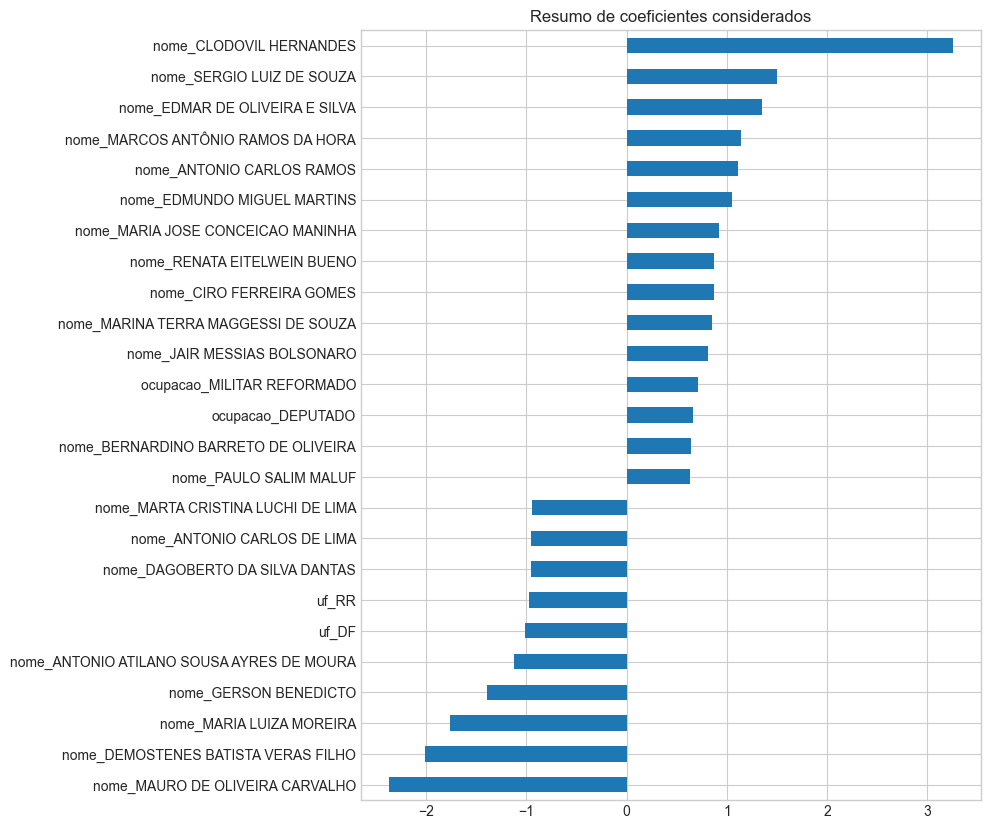

In [267]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
descricao_coeficientes.plot(kind= 'barh')
plt.title("Resumo de coeficientes considerados")

## 3.1 - Resíduos x Predições: Lasso

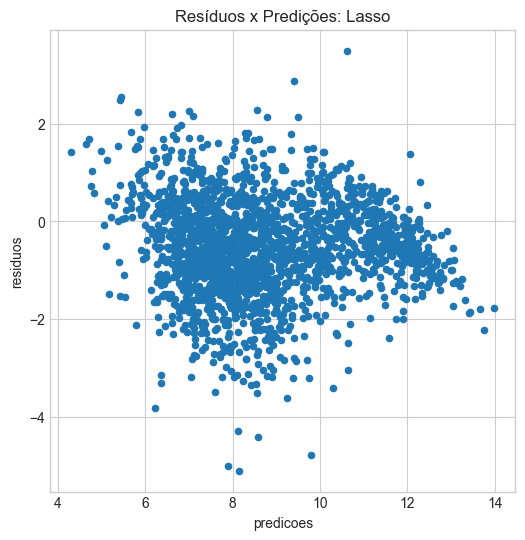

In [268]:
vis_residuos_vs_predicoes(y_pred_model_lasso, y_test, "Resíduos x Predições: Lasso")

A distribuição dos resíduos demonstra também uma boa adequabilidade, e possui aparencia muito semelhante ao do modelo Ridge. 

## 4 - Regressão com o KNN

In [269]:
from sklearn.neighbors import KNeighborsRegressor

In [270]:
model_knn = KNeighborsRegressor(n_neighbors=3).fit(x_train, y_train)

In [271]:
y_pred_model_knn = model_knn.predict(x_test)

In [272]:
y_pred_model_knn

array([ 5.53375409,  6.70713038, 11.61926918, ..., 10.48873496,
       10.22780787,  9.4623992 ])

### R² KNN

In [273]:
r2_score(y_test, y_pred_model_knn)

0.6547764753788887

### RMSE KNN

In [274]:
mse_knn = mean_squared_error(y_test, y_pred_model_knn)
np.sqrt(mse_knn)

1.1874984790798053

## 4.1 - Resíduos x Predições: KNN

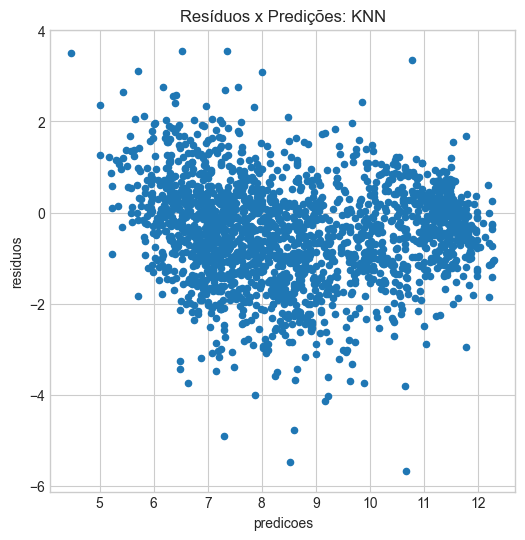

In [275]:
vis_residuos_vs_predicoes(y_pred_model_knn, y_test, "Resíduos x Predições: KNN")

## Resíduos X Predições dos Modelos

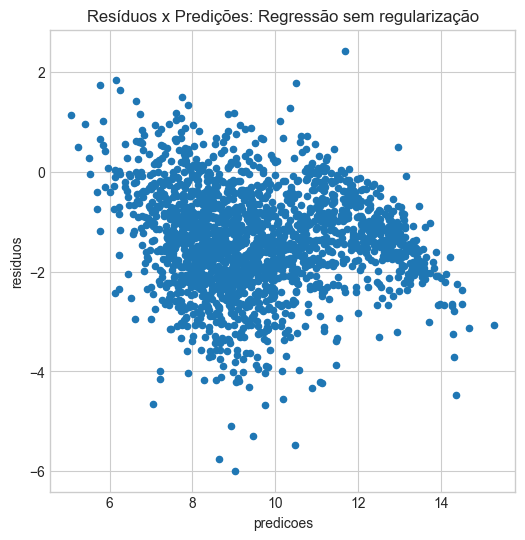

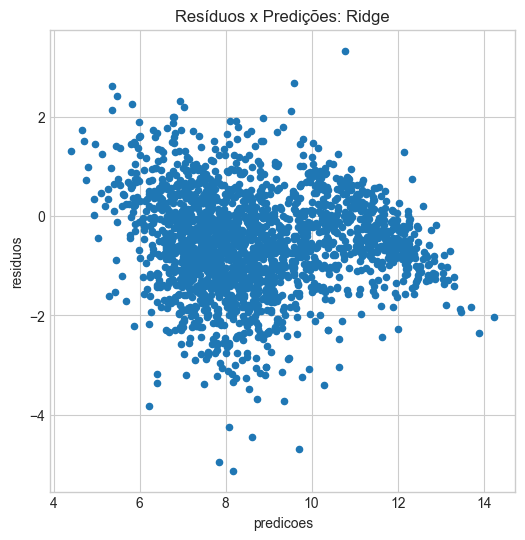

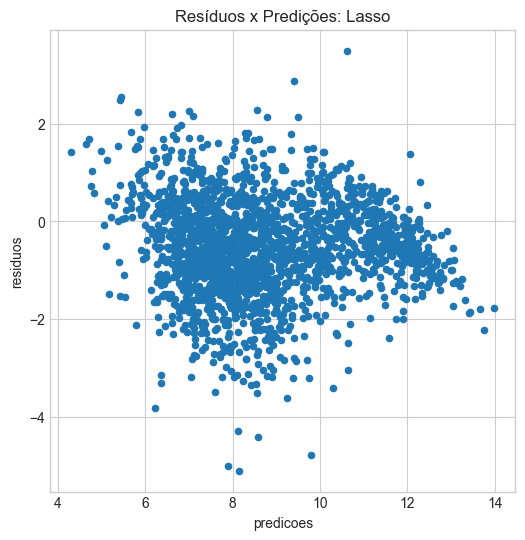

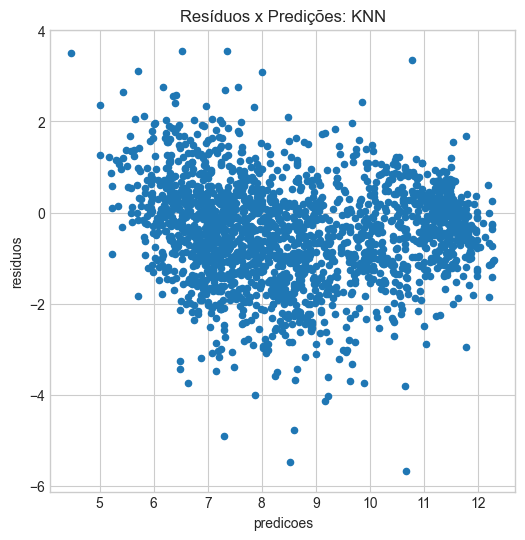

In [276]:
vis_residuos_vs_predicoes(y_pred_model_reg, y_test, "Resíduos x Predições: Regressão sem regularização")
vis_residuos_vs_predicoes(y_pred_model_ridge, y_test, "Resíduos x Predições: Ridge")
vis_residuos_vs_predicoes(y_pred_model_lasso, y_test, "Resíduos x Predições: Lasso")
vis_residuos_vs_predicoes(y_pred_model_knn, y_test, "Resíduos x Predições: KNN")

## Importando dados das eleições de 2014

In [277]:
eleicoes_2014 = pd.read_csv('eleicoes_2014.csv')
eleicoes_2014[:3]

,ano,sq_candidato,nome_candidato,sigla_uf,sigla_partido,qtd_doacoes,qtd_doadores,total_receita,media_receita,recursos de outros candidatos/comitês,...,qtd_despesas,qtd_fornecedores,total_despesa,media_despesa,descricao_cargo,sexo,grau_instrucao,estado_civil,descricao_ocupacao,votos
0,2014,10000000135,EMERSON DA SILVA SANTOS,AC,PSOL,3,3,1580.00,526.666667,NaN,...,3,3,1580.00,526.666667,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,SOLTEIRO(A),"CORRETOR DE IMÓVEIS, SEGUROS, TÍTULOS E VALORES",37
1,2014,10000000142,GERALDO SILVA DOS SANTOS,AC,PSOL,5,5,3180.00,636.000000,NaN,...,6,5,3130.02,626.004000,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,SOLTEIRO(A),VIGILANTE,383
2,2014,10000000158,CARLOS CESAR CORREIA DE MESSIAS,AC,PSB,40,38,333293.13,8770.871842,1923.07,...,145,139,326869.78,2351.581151,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL INCOMPLETO,CASADO(A),OUTROS,26448


In [278]:
numeric_features = eleicoes_2014.dtypes[eleicoes_2014.dtypes != "object"].index
skewed_features = eleicoes_2014[numeric_features].apply(lambda x: x.dropna().skew())
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features = skewed_features.index

In [279]:
eleicoes_2014[skewed_features] = np.log1p(eleicoes_2014[skewed_features])
eleicoes_2014 = eleicoes_2014.fillna(eleicoes_2014.mean())
eleicoes_2014[numeric_features][:5]

,ano,sq_candidato,qtd_doacoes,qtd_doadores,total_receita,media_receita,recursos de outros candidatos/comitês,recursos de pessoas físicas,recursos de pessoas jurídicas,recursos próprios,qtd_despesas,qtd_fornecedores,total_despesa,media_despesa,votos
0,2014,10000000135,1.386294,1.386294,7.365813,6.268465,8.442226,7.313887,10.039024,8.505303,1.386294,1.386294,7.365813,6.268465,3.637586
1,2014,10000000142,1.791759,1.791759,8.064951,6.456770,8.442226,8.039480,10.039024,8.505303,1.945910,1.791759,8.049114,6.440953,5.950643
2,2014,10000000158,3.713572,3.663562,12.716781,9.079305,7.562198,11.092869,11.945818,11.652696,4.983607,4.941642,12.697320,7.763268,10.182974
3,2014,10000000161,3.401197,3.401197,11.962218,8.595101,10.574474,11.138739,9.741027,8.826758,4.919981,4.804021,12.392623,7.597330,9.199987
4,2014,10000000163,5.081404,4.990433,13.474546,8.491143,9.210440,12.757293,12.531776,11.264477,6.251904,5.872118,13.248824,7.380149,9.946403


In [280]:
eleicoes_2014 = pd.get_dummies(eleicoes)
eleicoes_2014 = eleicoes_2014.drop(['sequencial_candidato', 'media_receita', 'media_despesa'], axis=1)
eleicoes_2014.shape

(7330, 7035)

## Testando dados de 2014 com o modelo Ridge que apresentou o melhor comportamento, quanto ao RMSE, nas análises anteriores.

In [281]:
x = eleicoes_2014.drop('votos', axis=1)
y = eleicoes_2014['votos']

y_pred_model_reg_eleicao_2014 = model_ridge.predict(x)
y_pred_model_reg_eleicao_2014

array([8.48154665, 8.01335902, 8.97451964, ..., 6.69772257, 6.47749814,
       7.61857984])

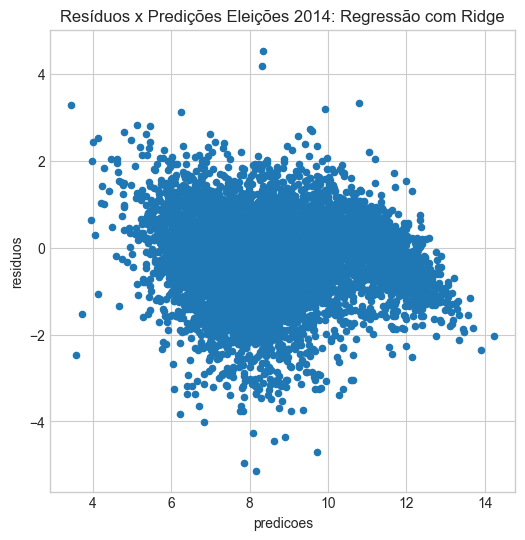

In [282]:
vis_residuos_vs_predicoes(y_pred_model_reg_eleicao_2014, y, "Resíduos x Predições Eleições 2014: Regressão com Ridge")

## RMSE com Ridge

In [283]:
mse_2014 = mean_squared_error(y, y_pred_model_reg_eleicao_2014)
np.sqrt(mse_2014)

0.9920754017100827

## Testando com Lasso

In [284]:
y_pred_model_reg_eleicao_2014_lasso = model_lasso.predict(x)
y_pred_model_reg_eleicao_2014_lasso

array([8.24445818, 8.03766096, 8.79739547, ..., 6.76455082, 6.666614  ,
       7.68627294])

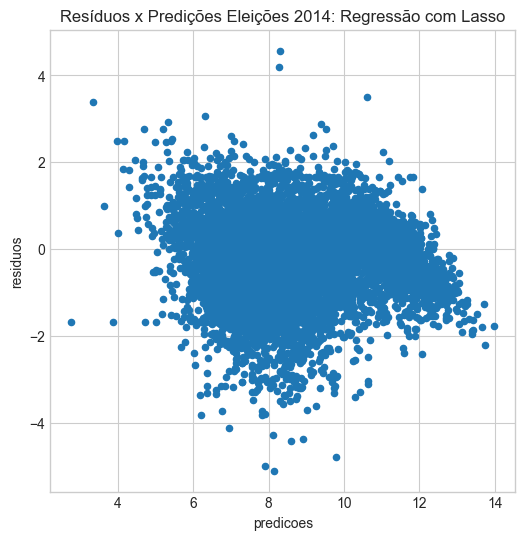

In [285]:
vis_residuos_vs_predicoes(y_pred_model_reg_eleicao_2014_lasso, y, "Resíduos x Predições Eleições 2014: Regressão com Lasso")

### RMSE com Lasso

In [286]:
mse_2014_lasso = mean_squared_error(y, y_pred_model_reg_eleicao_2014_lasso)
np.sqrt(mse_2014_lasso)

1.0256035182597658

## Dentre os modelos avaliados, qual foi o que deu o melhor resultado nos dados de 2014 em termos de RMSE? 

O modelo Ridge devido ao seu RMSE de 0,88 e também podemos observar que no gráfico ele apresenta uma maior concentração de dados no centro do gráfico.